In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils
from code_utils import ordinal_regression


In [7]:
n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [8]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])


In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'ordinal_regression_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()

dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'roi_names'])

In [6]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [254]:
si = 5; ss=subjects[si]
ri = 0;
ti = 1; tt = 2;
ii = 1;

pred = dec_withintask['preds_all'][si][ri][ti][ii]
prob = dec_withintask['probs_all'][si][ri][ti][ii]
                
# get labels for all the trials, this subject
main_labels = data_utils.load_main_task_labels(ss)
rep_labels = data_utils.load_repeat_task_labels(ss)
concat_labels = pd.concat([main_labels, rep_labels], axis=0)
pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
is_main_grid = concat_labels['is_main_grid']==1

task_inds = concat_labels['task']==tt

# actual labels for position along this axis
coord_actual = np.array(pt_labs[:,ii])[task_inds]

# is it a hard trial?
is_hard = ~is_main_grid[task_inds]

# which side of boundary was point? 1 = <center, 2=>center
categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)
categ_check = (coord_actual>center).astype(int) + 1
assert(np.all(categ_actual==categ_check))

# what category did the subject respond? 
categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
categ_subjresp[np.abs(categ_subjresp)>2] = 0;

# was the subject correct or incorrect?
correct = categ_subjresp==categ_actual

In [251]:
np.sum(prob<0)

179

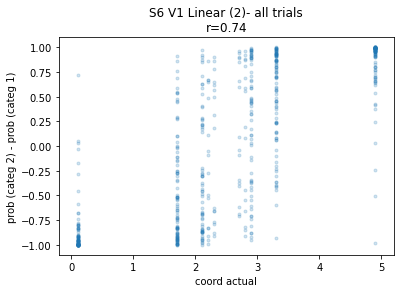

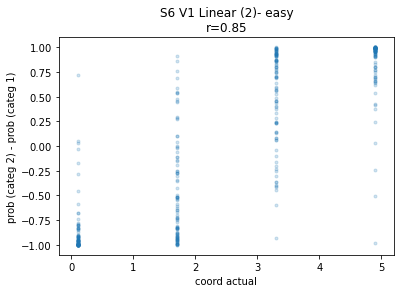

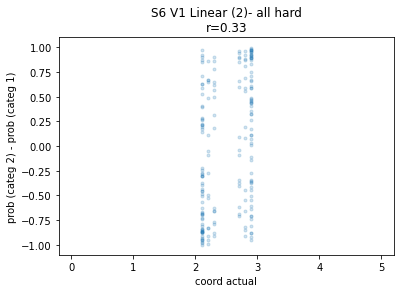

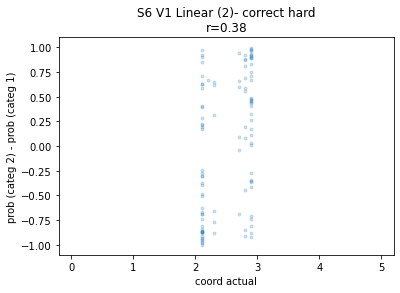

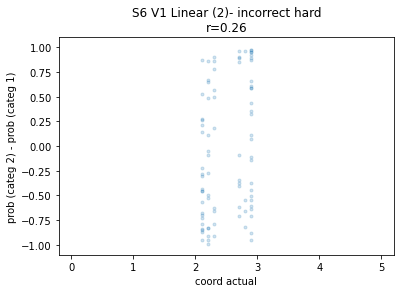

In [259]:
pdiff = (prob[:,2]+prob[:,3]) - (prob[:,1]+prob[:,0])

for inds, name in zip([np.ones(np.shape(is_hard),dtype=bool), \
                       ~is_hard, is_hard, is_hard & correct, is_hard & ~correct], \
                      ['all trials', 'easy', 'all hard','correct hard','incorrect hard']):
    plt.figure()

    plt.plot(coord_actual[inds], pdiff[inds], '.', alpha=0.2)
    plt.xlabel('coord actual')
    plt.ylabel('prob (categ 2) - prob (categ 1)')
    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
    plt.title('S%d %s %s- %s\nr=%.2f'%(subjects[si], roi_names[ri], task_names[ti], name, r));
    plt.xlim([-0.2, 5.2])
    plt.ylim([-1.1, 1.1])

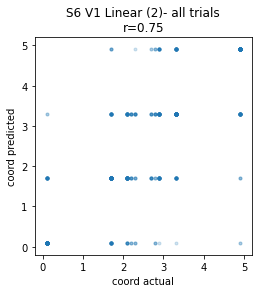

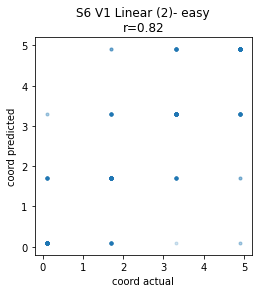

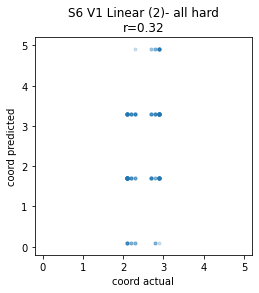

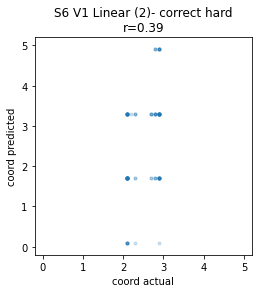

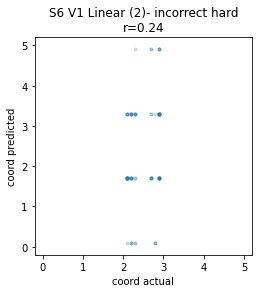

In [263]:

for inds, name in zip([np.ones(np.shape(is_hard),dtype=bool), \
                       ~is_hard, is_hard, is_hard & correct, is_hard & ~correct], \
                      ['all trials', 'easy', 'all hard','correct hard','incorrect hard']):
    plt.figure()

    plt.plot(coord_actual[inds], pred[inds], '.', alpha=0.2)
    plt.xlabel('coord actual')
    plt.ylabel('coord predicted')
    r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
    plt.title('S%d %s %s- %s\nr=%.2f'%(subjects[si], roi_names[ri], task_names[ti], name, r));
    plt.axis('square')
    plt.xlim([-0.2, 5.2])
    plt.ylim([-0.2, 5.2])
    

#### compute how accurate the predictions are

In [202]:
center_range = [1.7, 3.3]
center = 2.5

r_alltrials = np.zeros((n_subjects, n_rois, 2, 2))
r_easytrials = np.zeros((n_subjects, n_rois, 2, 2))
r_hardtrials = np.zeros((n_subjects, n_rois, 2, 2))
pr_hardtrials = np.zeros((n_subjects, n_rois, 2, 2))

r_hardtrials_centeronly = np.zeros((n_subjects, n_rois, 2, 2))
pr_hardtrials_centeronly = np.zeros((n_subjects, n_rois, 2, 2))

pr_hardtrials_correct = np.zeros((n_subjects, n_rois, 2))
pr_hardtrials_incorrect = np.zeros((n_subjects, n_rois, 2))

for si, ss in enumerate(subjects):

    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    concat_labels = pd.concat([main_labels, rep_labels], axis=0)
    pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
    is_main_grid = concat_labels['is_main_grid']==1
    
    for ti, tt in enumerate([1,2]):
        
        for ii in [0,1]:

            task_inds = concat_labels['task']==tt

            # actual labels for position along this axis
            coord_actual = np.array(pt_labs[:,ii])[task_inds]

            # is it a hard trial?
            is_hard = ~is_main_grid[task_inds]
            
            in_center = (coord_actual>center_range[0]) & (coord_actual<center_range[1])
            # print([ti, ii, np.mean(in_center)])
            
            if ii==ti:

                # which side of boundary was point? 1 = <center, 2=>center
                categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)
                categ_check = (coord_actual>center).astype(int) + 1
                assert(np.all(categ_actual==categ_check))

                # what category did the subject respond? 
                categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
                categ_subjresp[np.abs(categ_subjresp)>2] = 0;

                # was the subject correct or incorrect?
                correct = categ_subjresp==categ_actual

            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti][ii]
                prob = dec_withintask['probs_all'][si][ri][ti][ii]
                
                # all trials
                r,p = scipy.stats.pearsonr(coord_actual, pred)
                r_alltrials[si,ri,ti,ii] = r;
                
                # easy trials
                inds = ~is_hard
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_easytrials[si,ri,ti,ii] = r;
                
                # hard trials
                inds = is_hard
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_hardtrials[si,ri,ti,ii] = r;
               
                inds = is_hard
                # compute the probability difference for right side - left side
                pdiff = (prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0])
                r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                pr_hardtrials[si,ri,ti,ii] = r;
            
                # to make things fair across tasks, can take just the center points
                inds = is_hard & in_center
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_hardtrials_centeronly[si,ri,ti,ii] = r;
               
                inds = is_hard & in_center
                pdiff = (prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0])
                r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                pr_hardtrials_centeronly[si,ri,ti,ii] = r;
               
                # separate by incorrect/correct (only doing this for task-relevant axis)
                if ii==ti:
                    
                    inds = is_hard & correct
                    pdiff = (prob[inds,3]+prob[inds,2]) - (prob[inds,1]+prob[inds,0])
                    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)
                    pr_hardtrials_correct[si,ri,ti] = r;

                    inds = is_hard & ~correct
                    pdiff = (prob[inds,3]+prob[inds,2]) - (prob[inds,1]+prob[inds,0])
                    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)
                    pr_hardtrials_incorrect[si,ri,ti] = r;
                
            

In [216]:
np.mean(prob>0.50)

0.2126736111111111

#### for each task, plot how well the classifier predicts the category of hard trials
for correct/incorrect separately

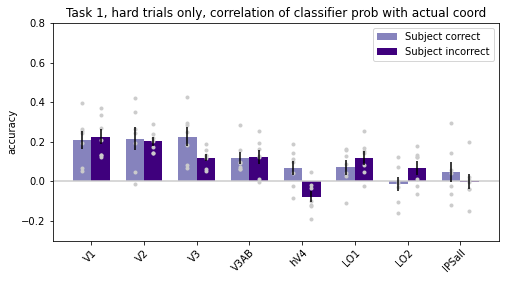

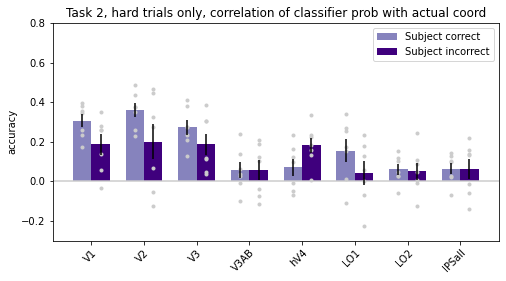

In [206]:
for ti in [0,1]:
    
    tt = ti+1

    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    vals = np.concatenate([pr_hardtrials_correct[:,:,ti:ti+1], pr_hardtrials_incorrect[:,:,ti:ti+1]], axis=2)

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               point_data = vals, \
                               add_ss_lines=False,
                               colors = colors, \
                               space = 0.15, \
                               title = 'Task %d, hard trials only, correlation of classifier prob with actual coord'%(tt), \
                               ylim = [-0.3, 0.8], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'accuracy', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = ['Subject correct', 'Subject incorrect'], \
                               fig_size=(8,4));

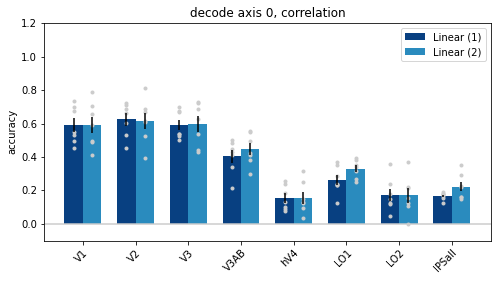

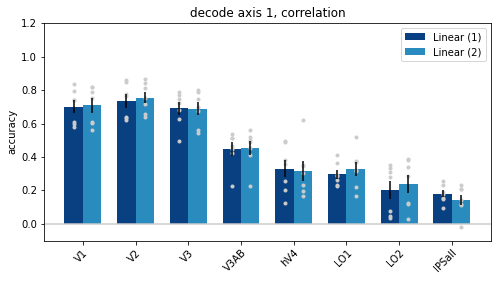

In [213]:
for ii in [0,1]:

    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    vals = r_easytrials[:,:,:,ii]
    # vals = pr_hardtrials_centeronly[:,:,:,ii]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               point_data = vals, \
                               add_ss_lines=False,
                               colors = task_colors[0:2,:], \
                               space = 0.15, \
                               title = 'decode axis %d, correlation'%(ii), \
                               ylim = [-0.1, 1.2], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'accuracy', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = task_names[0:2], \
                               fig_size=(8,4));

#### try pooling across subjects

In [217]:
pr_hardtrials_correct = np.zeros((n_rois, 2))
pr_hardtrials_incorrect = np.zeros((n_rois, 2))

for ri in range(n_rois):
    
    for ti,tt in enumerate([1,2]):

        actual_coord = []
        pdiff = []
        correct = []
        is_hard = []

        for si, ss in enumerate(subjects):

            # get labels for all the trials, this subjct
            main_labels = data_utils.load_main_task_labels(ss)
            rep_labels = data_utils.load_repeat_task_labels(ss)

            concat_labels = pd.concat([main_labels, rep_labels], axis=0)
            pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
            is_main_grid = concat_labels['is_main_grid']==1

            task_inds = concat_labels['task']==tt

            hard = ~is_main_grid[task_inds]

            # actual labels for position along this axis
            ii = ti;
            coord_actual = np.array(pt_labs[:,ii])[task_inds]

            # which side of boundary was point? 1 = <center, 2=>center
            categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)

            center = 2.5
            categ_check = (coord_actual>center).astype(int) + 1

            assert(np.all(categ_actual==categ_check))

            # what category did the subject respond? 
            categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
            categ_subjresp[np.abs(categ_subjresp)>2] = 0;

            # was the subject correct or incorrect?
            corr = categ_subjresp==categ_actual

            prob = dec_withintask['probs_all'][si][ri][ti][ii]


            actual_coord.append(coord_actual)

            pdiff.append((prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0]))
            # pdiff.append((prob[:,2]) - (prob[:,1]))

            correct.append(corr)

            is_hard.append(hard)


        actual_coord = np.concatenate(actual_coord, axis=0)
        pdiff = np.concatenate(pdiff, axis=0)
        correct = np.concatenate(correct, axis=0)
        is_hard = np.concatenate(is_hard, axis=0)

        inds = is_hard & correct
        r,p = scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])
        pr_hardtrials_correct[ri,ti] = r;

        inds = is_hard & ~correct
        r,p = scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])
        pr_hardtrials_incorrect[ri,ti] = r;

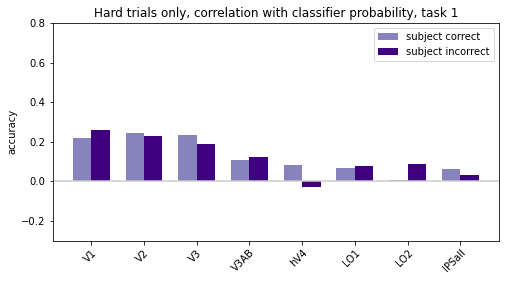

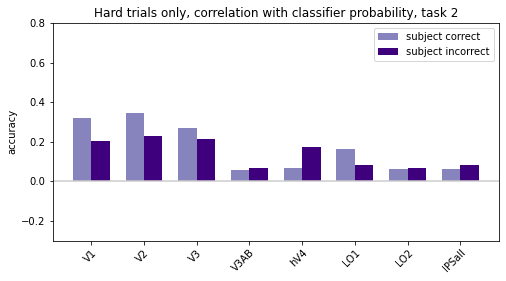

In [219]:
for ti in [0,1]:

    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    vals = np.concatenate([pr_hardtrials_correct[:,ti:ti+1], pr_hardtrials_incorrect[:,ti:ti+1]], axis=1)

    meanvals = vals
    semvals = []

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               add_ss_lines=False,
                               colors = colors, \
                               space = 0.15, \
                               title = 'Hard trials only, correlation with classifier probability, task %d'%(ti+1), \
                               ylim = [-0.3, 0.8], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'accuracy', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = ['subject correct', 'subject incorrect'], \
                              fig_size=(8,4));

(0.1380523229090388, 5.173753452272178e-07)

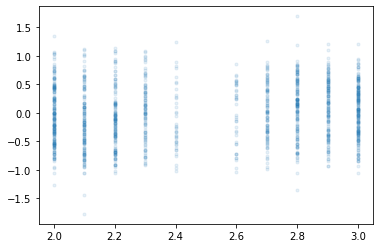

In [179]:
plt.figure()
inds = is_hard
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

861


(0.023713608282715272, 0.487111362592837)

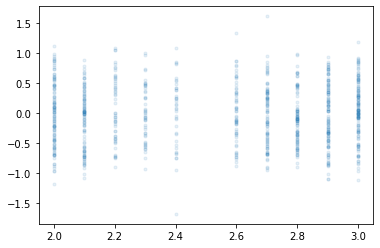

In [183]:
plt.figure()
inds = is_hard & correct
print(np.sum(inds))
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

483


(0.11455461804247008, 0.011756436965752527)

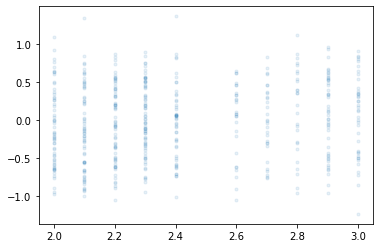

In [177]:
plt.figure()
inds = is_hard & ~correct
print(np.sum(inds))
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

In [149]:
categ_actual

array([2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1,

In [136]:
pred

array([4.9, 1.7, 1.7, 3.3, 4.9, 3.3, 1.7, 0.1, 1.7, 1.7, 3.3, 0.1, 1.7,
       4.9, 0.1, 3.3, 3.3, 3.3, 0.1, 3.3, 3.3, 3.3, 1.7, 1.7, 1.7, 0.1,
       3.3, 1.7, 1.7, 4.9, 3.3, 4.9, 3.3, 3.3, 0.1, 4.9, 3.3, 3.3, 0.1,
       1.7, 1.7, 4.9, 1.7, 3.3, 3.3, 4.9, 3.3, 3.3, 4.9, 4.9, 4.9, 3.3,
       0.1, 0.1, 3.3, 3.3, 1.7, 1.7, 3.3, 0.1, 1.7, 0.1, 1.7, 4.9, 1.7,
       1.7, 3.3, 4.9, 3.3, 4.9, 1.7, 4.9, 0.1, 4.9, 1.7, 1.7, 3.3, 3.3,
       0.1, 4.9, 1.7, 4.9, 4.9, 3.3, 0.1, 4.9, 1.7, 1.7, 3.3, 4.9, 1.7,
       3.3, 1.7, 1.7, 0.1, 3.3, 1.7, 3.3, 3.3, 0.1, 4.9, 3.3, 1.7, 0.1,
       0.1, 0.1, 3.3, 3.3, 3.3, 1.7, 4.9, 0.1, 0.1, 0.1, 1.7, 4.9, 1.7,
       0.1, 3.3, 3.3, 4.9, 1.7, 1.7, 3.3, 1.7, 4.9, 3.3, 4.9, 4.9, 1.7,
       4.9, 0.1, 0.1, 0.1, 3.3, 0.1, 1.7, 3.3, 1.7, 4.9, 3.3, 3.3, 0.1,
       1.7, 3.3, 1.7, 1.7, 1.7, 0.1, 1.7, 0.1, 1.7, 0.1, 3.3, 1.7, 3.3,
       1.7, 3.3, 3.3, 3.3, 1.7, 0.1, 1.7, 4.9, 0.1, 1.7, 0.1, 3.3, 3.3,
       4.9, 3.3, 0.1, 3.3, 3.3, 1.7, 0.1, 0.1, 4.9, 3.3, 1.7, 3.

In [110]:
# for si, ss in enumerate(subjects):
si = 0; ss = 1;

# get labels for all the trials, this subjct
main_labels = data_utils.load_main_task_labels(ss)
rep_labels = data_utils.load_repeat_task_labels(ss)
concat_labels = pd.concat([main_labels, rep_labels], axis=0)
pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
is_main_grid = concat_labels['is_main_grid']==1
grid_pts, grid_labs_main, counts = np.unique(pt_labs[is_main_grid], axis=0, return_inverse=True, return_counts=True)

# for ti, tt in enumerate([1,2]):

ti = 0; tt = 1;
ii = 1;
# ii = ti; # only consider same axis that was relevant in this task

task_inds = concat_labels['task']==tt

# actual labels for position along this axis
coord_actual = np.array(pt_labs[:,ii])[task_inds]
# which side of boundary was point? 1 = <center, 2=>center
categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)

center = 2.5
categ_check = (coord_actual>center).astype(int) + 1

# assert(np.all(categ_actual==categ_check))

# what category did the subject respond? 
categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
categ_subjresp[np.abs(categ_subjresp)>2] = 0;

# was the subject correct or incorrect?
# correct = categ_subjresp==categ_actual

# is it a hard trial?
is_hard = ~is_main_grid[task_inds]

ri = 0;
# for ri in range(n_rois):

pred = dec_withintask['preds_all'][si][ri][ti][ii]
prob = dec_withintask['probs_all'][si][ri][ti][ii]

# convert the classifier's prediction to binary category
categ_classpred = (pred>1).astype(int)+1

acc_easy = np.mean(categ_actual[~is_hard]==categ_classpred[~is_hard])
acc_hard = np.mean(categ_actual[is_hard]==categ_classpred[is_hard])

# inds = is_hard & correct

# pdiff = prob[inds,3] - prob[inds,0]

# r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)

# r_hardtrials_correct[si,ri,ti] = r;


# inds = is_hard & ~correct

# pdiff = prob[inds,3] - prob[inds,0]

# r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)

# r_hardtrials_incorrect[si,ri,ti] = r;


(0.5514010233656854, 3.9833945609404763e-47)


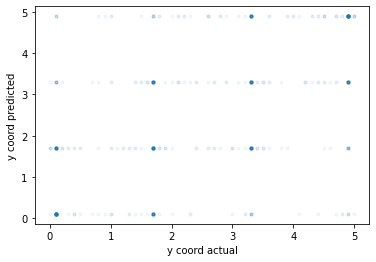

In [112]:
plt.figure()
plt.plot(coord_actual, pred, '.', alpha=0.05)
plt.xlabel('y coord actual')
plt.ylabel('y coord predicted')
print(scipy.stats.pearsonr(coord_actual, pred))

(0.1432805334793571, 0.047408714693625856)


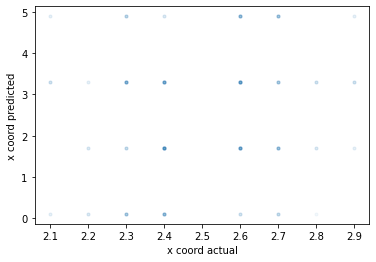

In [81]:
plt.figure()
plt.plot(coord_actual[is_hard], pred[is_hard], '.', alpha=0.05)
plt.xlabel('x coord actual')
plt.ylabel('x coord predicted')
print(scipy.stats.pearsonr(coord_actual[is_hard], pred[is_hard]))

(0.0966233486188012, 0.18245589979329974)


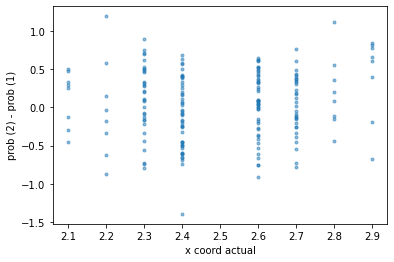

In [82]:
pdiff = prob[is_hard,2] - prob[is_hard,1]

plt.figure()

plt.plot(coord_actual[is_hard], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[is_hard], pdiff))

(0.1860365131972722, 0.045557936036997565)


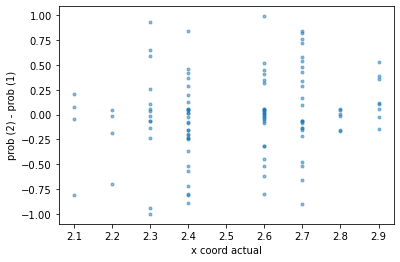

In [83]:
inds = is_hard & correct

pdiff = prob[inds,3] - prob[inds,0]

plt.figure()

plt.plot(coord_actual[inds], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[inds], pdiff))

(0.07196635167837917, 0.5367123862216652)


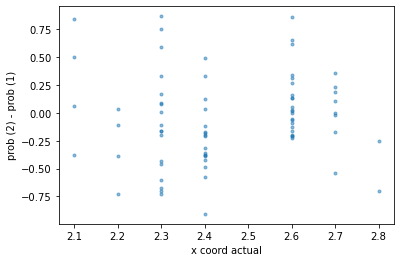

In [84]:
inds = is_hard & ~correct

pdiff = prob[inds,3] - prob[inds,0]

plt.figure()

plt.plot(coord_actual[inds], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[inds], pdiff))